# Diabetes Risk Prediction and Feature Selection
**Objective**: Use the BRFSS dataset to create a short form of questions (features) to accurately predict diabetes risk.


In [6]:
# Import Necessary Libraries 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


In [7]:
# Load dataset and Inspect Data 
file_path = "./data/diabetes_binary_health_indicators_BRFSS2015.csv"
df = pd.read_csv(file_path)

# Inspect data
print(f"Dataset Shape: {df.shape}")
print(df.head())


Dataset Shape: (253680, 22)
   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      

In [8]:
#Define Features and Target

# Define features (X) and target (y)
X = df.drop(columns=["Diabetes_binary"])
y = df["Diabetes_binary"]

print(f"Features Shape: {X.shape}")
print(f"Target Shape: {y.shape}")


Features Shape: (253680, 21)
Target Shape: (253680,)


In [9]:
# Split Dataset 

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Target Distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing Target Distribution:\n{y_test.value_counts(normalize=True)}")


Training Features Shape: (177576, 21)
Testing Features Shape: (76104, 21)
Training Target Distribution:
Diabetes_binary
0.0    0.860668
1.0    0.139332
Name: proportion, dtype: float64
Testing Target Distribution:
Diabetes_binary
0.0    0.860664
1.0    0.139336
Name: proportion, dtype: float64


In [10]:
#Apply SMOTE to Training Data 

# Apply SMOTE to balance the training target variable
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Inspect the resampled data
print(f"Resampled Training Features Shape: {X_train_resampled.shape}")
print(f"Resampled Training Target Distribution:\n{pd.Series(y_train_resampled).value_counts(normalize=True)}")


Resampled Training Features Shape: (305668, 21)
Resampled Training Target Distribution:
Diabetes_binary
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


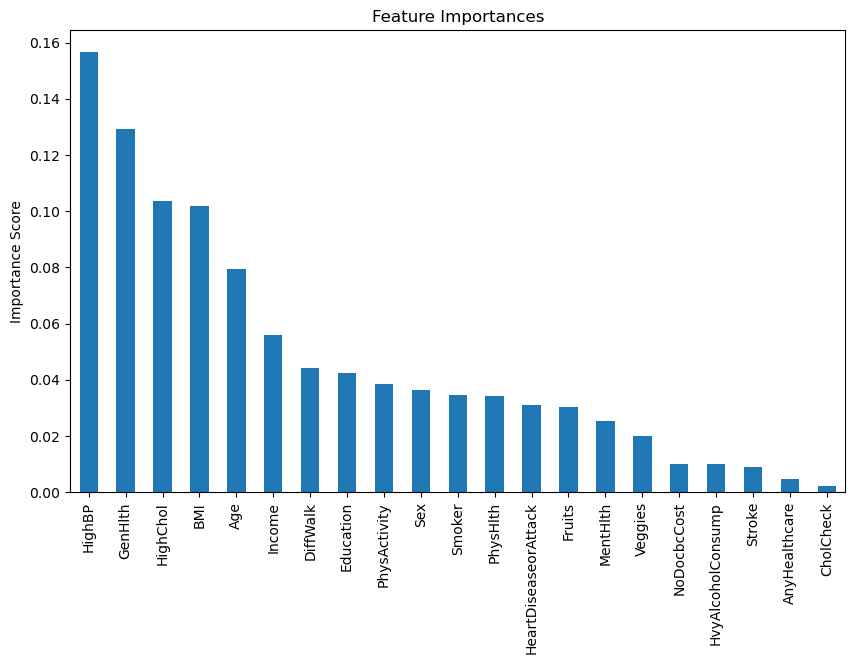

Selected Features: ['HighBP', 'GenHlth', 'HighChol', 'BMI', 'Age']


In [11]:
# Train Random Forest and Slected Features 

# Train a Random Forest model for feature importance
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Get feature importances
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind="bar")
plt.title("Feature Importances")
plt.ylabel("Importance Score")
plt.show()

# Select top N features
N = 5  # Adjust as needed
top_features = feature_importances.index[:N]
print(f"Selected Features: {list(top_features)}")


In [12]:
# Create reduced Datasets 

# Convert resampled training set to DataFrame
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)

# Create reduced datasets using the selected top features
X_train_reduced = X_train_resampled[top_features]
X_test_reduced = X_test[top_features]

print(f"Reduced Training Features Shape: {X_train_reduced.shape}")
print(f"Reduced Testing Features Shape: {X_test_reduced.shape}")

Reduced Training Features Shape: (305668, 5)
Reduced Testing Features Shape: (76104, 5)


In [13]:
# Train and Evaluate Model with Reduced Features 

from sklearn.metrics import classification_report, accuracy_score

# Train a Random Forest model with reduced features
clf_reduced = RandomForestClassifier(random_state=42)
clf_reduced.fit(X_train_reduced, y_train_resampled)

# Predict and evaluate on the reduced test set
y_pred_reduced = clf_reduced.predict(X_test_reduced)

# Print classification report and accuracy
print("Classification Report (Reduced Features):")
print(classification_report(y_test, y_pred_reduced))

accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
print(f"Accuracy with Reduced Features: {accuracy_reduced:.2f}")


Classification Report (Reduced Features):
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92     65500
         1.0       0.44      0.28      0.34     10604

    accuracy                           0.85     76104
   macro avg       0.67      0.61      0.63     76104
weighted avg       0.83      0.85      0.84     76104

Accuracy with Reduced Features: 0.85


In [14]:
# Compare Full and Reduced Models 

# Evaluate the full model (trained on all features) for comparison
y_pred_full = clf.predict(X_test)
accuracy_full = accuracy_score(y_test, y_pred_full)

# Compare full and reduced feature model accuracy
print(f"Accuracy with Full Features: {accuracy_full:.2f}")
print(f"Accuracy with Reduced Features: {accuracy_reduced:.2f}")

Accuracy with Full Features: 0.86
Accuracy with Reduced Features: 0.85


In [15]:
# Save the Slected Features and Model 

# Save selected features
pd.DataFrame(top_features, columns=["Feature"]).to_csv("selected_features.csv", index=False)

# Save the reduced model
import joblib
joblib.dump(clf_reduced, "reduced_model.pkl")

print("Selected features and model saved.")

Selected features and model saved.


In [16]:
# Hyperparameter Tuning: Optimize the Random Forest model for better performance

from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='recall',  # Optimize for recall to improve minority class prediction
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train_reduced, y_train_resampled)

# Get the best parameters and model
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In [17]:
# Evaluate Tuned Model: Compare the tuned model's performance with the baseline

# Evaluate the best model on the test set
from sklearn.metrics import classification_report, accuracy_score

y_pred = best_model.predict(X_test_reduced)

print("Tuned Random Forest Results on Test Set:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Tuned Random Forest Results on Test Set:
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89     65500
         1.0       0.38      0.54      0.45     10604

    accuracy                           0.81     76104
   macro avg       0.65      0.70      0.67     76104
weighted avg       0.84      0.81      0.83     76104

Accuracy: 0.81


In [21]:
# Logistic Regression Model: Train and Evaluate Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Ensure consistent training data by selecting the reduced features from the original dataset
# Define these globally so all models can use them
X_train_reduced = X_train[top_features]  # Changed to global variables
X_test_reduced = X_test[top_features]

# Train Logistic Regression on the reduced feature set
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train_reduced, y_train)

# Predict on the original test set
y_pred_logreg = logreg.predict(X_test_reduced)

# Evaluate Logistic Regression
print("Logistic Regression Results on Original Test Set:")
print(classification_report(y_test, y_pred_logreg))
print(f"Accuracy on Original Test Set: {accuracy_score(y_test, y_pred_logreg):.2f}")

Logistic Regression Results on Original Test Set:
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     65500
         1.0       0.30      0.76      0.43     10604

    accuracy                           0.72     76104
   macro avg       0.63      0.74      0.63     76104
weighted avg       0.86      0.72      0.76     76104

Accuracy on Original Test Set: 0.72


In [22]:
# Gradient Boosting Model: 

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train Gradient Boosting (XGBoost) on the reduced feature set
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train_reduced, y_train)

# Predict on the test set
y_pred_xgb = xgb.predict(X_test_reduced)

# Evaluate Gradient Boosting
print("XGBoost Results on Original Test Set:")
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy on Original Test Set: {accuracy_score(y_test, y_pred_xgb):.2f}")

/opt/anaconda3/envs/python310_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:20:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results on Original Test Set:
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93     65500
         1.0       0.55      0.14      0.22     10604

    accuracy                           0.86     76104
   macro avg       0.71      0.56      0.57     76104
weighted avg       0.83      0.86      0.83     76104

Accuracy on Original Test Set: 0.86


In [23]:
# Hyperparameter Tuning for XGBoost: This cell uses GridSearchCV to optimize XGBoost hyperparameters.

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform GridSearchCV
xgb_grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric="logloss"),
    param_grid=param_grid,
    scoring='recall',  # Optimize for recall to improve minority class performance
    cv=5,
    n_jobs=-1
)

xgb_grid_search.fit(X_train_reduced, y_train)

# Get the best parameters and model
best_xgb_model = xgb_grid_search.best_estimator_
print(f"Best Parameters for XGBoost: {xgb_grid_search.best_params_}")

Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [24]:
# Weighted XGBoost with Class Weights: This cell uses the scale_pos_weight parameter to address class imbalance.

# Re-train XGBoost with scale_pos_weight for class imbalance
xgb_weighted = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=len(y_train) / sum(y_train)  # Class weight adjustment
)

xgb_weighted.fit(X_train_reduced, y_train)

# Predict on the test set
y_pred_xgb_weighted = xgb_weighted.predict(X_test_reduced)

# Evaluate the weighted XGBoost model
print("Weighted XGBoost Results on Original Test Set:")
print(classification_report(y_test, y_pred_xgb_weighted))
print(f"Accuracy on Original Test Set: {accuracy_score(y_test, y_pred_xgb_weighted):.2f}")

Weighted XGBoost Results on Original Test Set:
              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78     65500
         1.0       0.28      0.82      0.42     10604

    accuracy                           0.69     76104
   macro avg       0.62      0.74      0.60     76104
weighted avg       0.86      0.69      0.73     76104

Accuracy on Original Test Set: 0.69


In [25]:
# XGBoost with SMOTEENN: This cell trains XGBoost on a dataset balanced using the SMOTEENN technique.

from imblearn.combine import SMOTEENN

# Apply SMOTEENN to the training dataset
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train_reduced, y_train)

# Train XGBoost with SMOTEENN data
xgb_smoteenn = XGBClassifier(random_state=42, eval_metric="logloss")
xgb_smoteenn.fit(X_train_smoteenn, y_train_smoteenn)

# Predict on the test set
y_pred_xgb_smoteenn = xgb_smoteenn.predict(X_test_reduced)

# Evaluate the SMOTEENN XGBoost model
print("SMOTEENN XGBoost Results on Original Test Set:")
print(classification_report(y_test, y_pred_xgb_smoteenn))
print(f"Accuracy on Original Test Set: {accuracy_score(y_test, y_pred_xgb_smoteenn):.2f}")

SMOTEENN XGBoost Results on Original Test Set:
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92     65500
         1.0       0.47      0.23      0.31     10604

    accuracy                           0.86     76104
   macro avg       0.68      0.59      0.61     76104
weighted avg       0.83      0.86      0.83     76104

Accuracy on Original Test Set: 0.86


In [26]:
# Ensemble Voting Classifier: This cell combines XGBoost, Random Forest, and Logistic Regression in a voting ensemble for better overall performance.

from sklearn.ensemble import VotingClassifier

# Define the individual models
logreg = LogisticRegression(class_weight='balanced', random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, eval_metric="logloss")

# Create the ensemble voting classifier
voting_clf = VotingClassifier(
    estimators=[('logreg', logreg), ('rf', rf), ('xgb', xgb)],
    voting='soft'  # Use probabilities for better recall
)

# Train the ensemble model
voting_clf.fit(X_train_reduced, y_train)

# Predict on the test set
y_pred_voting = voting_clf.predict(X_test_reduced)

# Evaluate the ensemble model
print("Ensemble Voting Classifier Results on Original Test Set:")
print(classification_report(y_test, y_pred_voting))
print(f"Accuracy on Original Test Set: {accuracy_score(y_test, y_pred_voting):.2f}")

Ensemble Voting Classifier Results on Original Test Set:
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     65500
         1.0       0.46      0.33      0.39     10604

    accuracy                           0.85     76104
   macro avg       0.68      0.63      0.65     76104
weighted avg       0.84      0.85      0.84     76104

Accuracy on Original Test Set: 0.85


In [29]:
from joblib import dump

# Save the model
dump(xgb_weighted, 'weighted_xgboost_model.joblib')

print("Model saved as 'weighted_xgboost_model.joblib'")

Model saved as 'weighted_xgboost_model.joblib'


In [30]:
from joblib import load

# Load the saved model
loaded_model = load('weighted_xgboost_model.joblib')

# Test the loaded model with the test dataset
y_pred_loaded = loaded_model.predict(X_test_reduced)

# Evaluate the loaded model's predictions
from sklearn.metrics import classification_report, accuracy_score
print("Loaded Model Results:")
print(classification_report(y_test, y_pred_loaded))
print(f"Accuracy: {accuracy_score(y_test, y_pred_loaded):.2f}")

Loaded Model Results:
              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78     65500
         1.0       0.28      0.82      0.42     10604

    accuracy                           0.69     76104
   macro avg       0.62      0.74      0.60     76104
weighted avg       0.86      0.69      0.73     76104

Accuracy: 0.69


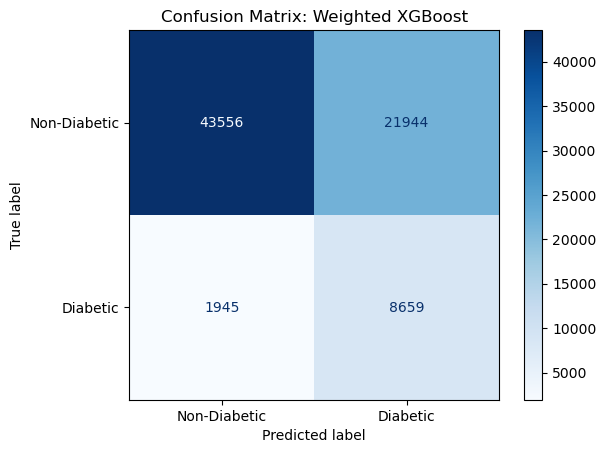

In [31]:
# Results Visualization (Confusion Matrix): The confusion matrix gives a clear representation of the model's performance by showing true positives, true negatives, false positives, and false negatives.

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(
    loaded_model, X_test_reduced, y_test, display_labels=["Non-Diabetic", "Diabetic"], cmap="Blues"
)
plt.title("Confusion Matrix: Weighted XGBoost")
plt.show()

In [32]:
# Deploy the Model as a Flask API

# Flask Script: 

from flask import Flask, request, jsonify
from joblib import load
import numpy as np

app = Flask(__name__)

# Load the saved model
model = load("weighted_xgboost_model.joblib")

# Define the prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    # Parse input JSON
    data = request.get_json()
    features = np.array(data["features"]).reshape(1, -1)  # Reshape for a single sample
    
    # Make prediction
    prediction = model.predict(features)
    probability = model.predict_proba(features)

    # Respond with prediction and probabilities
    return jsonify({
        "prediction": int(prediction[0]),
        "probability": probability.tolist()
    })

if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat
Traceback (most recent call last):
  File "/opt/anaconda3/envs/python310_env/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/python310_env/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/python310_env/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/python310_env/lib/python3.10/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/opt/anaconda3/envs/python310_env/lib/python3.10/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
  File "/opt/anaconda3/envs/python310_env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 654, in initialize
    self.init_sockets()
  Fi

SystemExit: 1

/opt/anaconda3/envs/python310_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
